# High Performance Python

## Charged Particle Simulations

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def gen_particles(N, dist="Circle"):
    if dist == "Circle":
        coords = np.ones((N, 2))
        r = np.arange(0, N)
        coords[:, 0] = 0.5 + 0.3*np.sin(2*np.pi*r/N + 0.1)
        coords[:, 1] = 0.5 + 0.3*np.cos(2*np.pi*r/N + 0.1)
        return coords
    elif dist == "Random":
        return np.random.rand(N, 2)
    else:
        raise ValueError(f"Unrecognised distribution {dist}.")
    


def plot_potential_grid(potential_grid):
    plt.imshow(potential_grid, origin="lower")
    plt.axis("off")

In [3]:
GPU_NAME = "Intel"

NUM_PARTICLES = 10
GRID_RESOLUTION = 500
PARTICLE_COORDS = gen_particles(NUM_PARTICLES, dist="Random")
CHARGES = np.random.choice(np.int32([-1, 1]), (NUM_PARTICLES, ))

benchmarks = {}
functions_dict = {}

### Python Loops

In [4]:
def V_potential(grid_pos, particle_coords, k):
    """
    Determine potential at a given grid point by 
    summing the contribution from each particle
    """
    V = 0
    for j in range(len(particle_coords)):
        dist = np.linalg.norm(grid_pos - particle_coords[j])
        if dist > 0:
            V -= k[j]*np.log(dist)
        else:
            V -= k[j]*np.inf
    return V


def potential_py(particle_coords, grid_resolution, charges):
    potential_grid = np.zeros((grid_resolution, grid_resolution))
    for i in range(len(potential_grid)):
        for m in range(len(potential_grid[i])):
            grid_pos = np.asarray([i, m])/grid_resolution
            potential_grid[m,i] = V_potential(
                grid_pos, particle_coords, charges
            )
    return potential_grid


functions_dict["py"] = potential_py

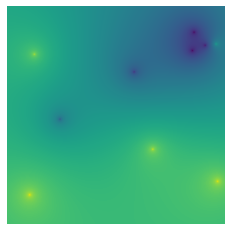

In [5]:
potential_grid_py = potential_py(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_py);

In [6]:
benchmarks["py"] = %timeit -o potential_py(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

29.1 s ± 876 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numpy

In [7]:
def potential_np(particle_coords, grid_resolution, charges):
    # Create mesh xx, yy
    x = np.linspace(0, 1, grid_resolution)
    y = np.linspace(0, 1, grid_resolution)
    xx, yy = np.meshgrid(x, y)

    # Create matrix of zeros
    potential_grid = np.zeros((grid_resolution, grid_resolution))

    # Increment the matrix for each particle
    for i in range(len(particle_coords)):
        delta_x = np.square(xx - particle_coords[i, 0])
        delta_y = np.square(yy - particle_coords[i, 1])
        distance = np.sqrt(delta_x + delta_y)
        potential_grid += -charges[i]*np.log(distance)

    return potential_grid


functions_dict["np"] = potential_np

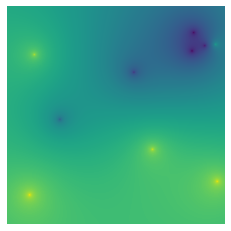

In [8]:
potential_grid_np = potential_np(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_np)

In [9]:
benchmarks["np"] = %timeit -o potential_np(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

107 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Numba

In [10]:
from numba import jit

In [11]:
@jit(nopython=True)
def V_potential_numba(grid_pos, particle_coords, k):
    V = 0
    for j in range(len(particle_coords)):
        dist = np.sqrt(np.sum(np.square(grid_pos - particle_coords[j])))
        if dist > 0:
            V -= k[j]*np.log(dist)
        else:
            V -= k[j]*np.inf
    return V


@jit(nopython=True)
def potential_numba(particle_coords, grid_resolution, charges):
    potential_grid = np.zeros((grid_resolution, grid_resolution))
    for i in range(grid_resolution):
        for m in range(grid_resolution):
            grid_pos = np.asarray([i, m])/grid_resolution
            potential_grid[m,i] = V_potential_numba(grid_pos, 
                                                    particle_coords, 
                                                    charges)
    return potential_grid


functions_dict["numba"] = potential_numba

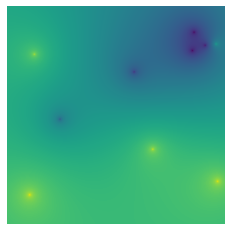

In [12]:
potential_grid_numba = potential_numba(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_numba)

In [13]:
benchmarks["numba"] = %timeit -o potential_numba(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

430 ms ± 6.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cython

In [14]:
%load_ext Cython

In [15]:
%%cython
import numpy as np
cimport numpy as np
import math

DTYPE = np.float64

cpdef double V_potential_cython(
    double[:] grid_pos, double[:, :] particle_coords, int[:] k
):
    cdef double V = 0.0
    cdef double x_dist
    cdef double y_dist
    cdef double dist
    
    for j in range(len(particle_coords)):
        x_dist = grid_pos[0] - particle_coords[j][0]
        y_dist = grid_pos[1] - particle_coords[j][1]
        dist = math.sqrt(x_dist**2 + y_dist**2)
        if dist > 0:
            V -= k[j]*math.log(dist)
        else:
            V -= k[j]*math.inf
    return V


cpdef np.ndarray[double, ndim=2] potential_cython(
    double[:, :] particle_coords, 
    int grid_resolution, 
    int[:] charges
):
    cdef np.ndarray[double, ndim=2] potential_grid
    cdef np.ndarray[double, ndim=1] grid_pos
    
    grid_pos = np.zeros((2,), DTYPE)
    potential_grid = np.zeros((grid_resolution, grid_resolution))
    for i in range(grid_resolution):
        for m in range(grid_resolution):
            grid_pos[0] = i/grid_resolution
            grid_pos[1] = m/grid_resolution
            potential_grid[m, i] = V_potential_cython(
                grid_pos, particle_coords, charges
            )
    return potential_grid

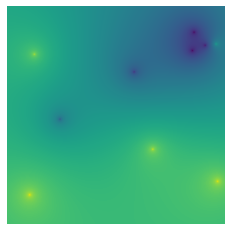

In [16]:
functions_dict["cython"] = potential_cython

potential_grid_cython = potential_cython(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_cython)

In [17]:
benchmarks["cython"] = %timeit -o potential_cython(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

1.55 s ± 92.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### C++ with pybind11

In [18]:
from pyhpc_cpp import calc_potential_grid


def potential_cpp(
    particle_coords, grid_resolution, charges, num_threads=1
):
    x_coords = particle_coords[:, 0]
    y_coords = particle_coords[:, 1]
    grid = calc_potential_grid(
        x_coords, y_coords, grid_resolution, charges, num_threads
    )
    return np.reshape(grid, (grid_resolution, grid_resolution))


functions_dict["cpp"] = potential_cpp

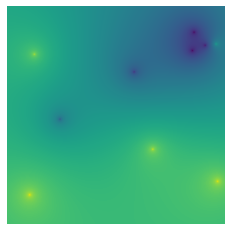

In [19]:
charges = CHARGES.astype('int32')

potential_grid_cpp = potential_cpp(
    PARTICLE_COORDS, GRID_RESOLUTION, charges
)
plot_potential_grid(potential_grid_cpp)

In [20]:
benchmarks["cpp"] = %timeit -o potential_cpp(PARTICLE_COORDS, GRID_RESOLUTION, charges)

41.4 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### With multithreading using OpenMP

In [21]:
import os
MAX_THREADS = os.cpu_count()


def potential_cpp_omp(
    particle_coords, grid_resolution, charges, num_threads=MAX_THREADS
):
    return potential_cpp(particle_coords, grid_resolution, charges, num_threads)


functions_dict["cpp-omp"] = potential_cpp_omp

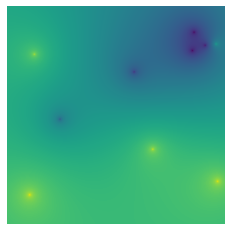

In [22]:
potential_grid_omp = potential_cpp(
    PARTICLE_COORDS, GRID_RESOLUTION, charges
)
plot_potential_grid(potential_grid_omp)

In [23]:
benchmarks["cpp-omp"] = %timeit -o potential_grid_omp = potential_cpp_omp(PARTICLE_COORDS, GRID_RESOLUTION, charges)

15.2 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### PyOpenCL

In [24]:
open_cl_kernel = """
__kernel void potential_cl(
    __global const double *x_pos_buf,
    __global const double *y_pos_buf,
    __global const double *x_grid_buf,
    __global const double *y_grid_buf,
    __global const int *charges_buf,
    const long grid_resolution,
    const long num_particles,
    __global double *potential_grid_buf
) {{
    double x_step, y_step, dist;
    int index;

    long i = get_global_id(0);
    long j = get_global_id(1);

    for (int k = 0; k < num_particles; ++k) {{
        x_step = x_grid_buf[i] - x_pos_buf[k];
        y_step = y_grid_buf[j] - y_pos_buf[k];
        dist = sqrt(x_step*x_step + y_step*y_step);
        
        index = i + grid_resolution*j;
        potential_grid_buf[index] -= charges_buf[k]*log(dist);
    }}
}}
"""

In [25]:
import pyopencl as cl

from cl_utils import get_device


class PotentialCL:
    """
    Use a class for this so the compilation of the kernel can be
    performed in the constructor.
    """
    
    def __init__(self, kernel, device_type=None, device_name=None):
        # Create a context and compile the OpenCL kernel for the device
        if all([x is None for x in [device_type, device_name]]):
            self.context = cl.create_some_context()
        else:
            device = get_device(device_type, device_name)
            self.context = cl.Context([device])
        self.queue = cl.CommandQueue(self.context)
        self.mf = cl.mem_flags
        self.program = cl.Program(self.context, kernel).build()
        
    def __call__(self, particle_coords, grid_resolution, charges):
        return self.run(particle_coords, grid_resolution, charges)
        
    def run(self, particle_coords, grid_resolution, charges):
        # TODO: some validation on input lengths
        x_pos = particle_coords[:, 0].astype("float64")
        y_pos = particle_coords[:, 1].astype("float64")
        x_grid = np.linspace(0, 1, grid_resolution, dtype="float64")
        y_grid = np.linspace(0, 1, grid_resolution, dtype="float64")
        charges = charges.astype("int32")
        num_particles = np.int64(len(charges))
        grid_resolution = np.int64(grid_resolution)
        potential_grid = np.zeros(grid_resolution**2, dtype="float64")

        # Create the OpenCL memory buffers to pass to the kernerl
        x_pos_buf = self._get_buffer(x_pos, "READ_ONLY")
        y_pos_buf = self._get_buffer(y_pos, "READ_ONLY")
        x_grid_buf = self._get_buffer(x_grid, "READ_ONLY")
        y_grid_buf = self._get_buffer(y_grid, "READ_ONLY")
        charges_buf = self._get_buffer(charges, "READ_ONLY")
        potential_grid_buf = self._get_buffer(potential_grid, "WRITE_ONLY")
        
        global_id_sizes = (grid_resolution, grid_resolution,)
        kernel_args = (
            x_pos_buf, 
            y_pos_buf, 
            x_grid_buf, 
            y_grid_buf, 
            charges_buf, 
            grid_resolution, 
            num_particles,
            potential_grid_buf
        )
        self.program.potential_cl(self.queue, global_id_sizes, None, *kernel_args)

        cl.enqueue_copy(self.queue, potential_grid, potential_grid_buf)
        potential_grid = potential_grid.reshape(
            (grid_resolution, grid_resolution)
        )

        return potential_grid
    
    def _get_buffer(self, hostbuf, permissions):
        mf = cl.mem_flags
        if permissions == "READ_ONLY":
            p_flag = mf.READ_ONLY
        elif permissions == "WRITE_ONLY":
            p_flag = mf.WRITE_ONLY
        else:
            raise ValueError(
                "'permission', must be 'READ_ONLY' or 'WRITE_ONLY'."
            )
        return cl.Buffer(
            self.context, p_flag | mf.COPY_HOST_PTR, hostbuf=hostbuf
        )

#### Using the CPU

C:\Users\hsaun\miniconda3\envs\hpc\lib\site-packages\pyopencl\__init__.py:269: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


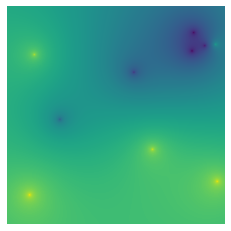

In [26]:
potential_cl_cpu = PotentialCL(open_cl_kernel, device_type="CPU")
functions_dict["cl-cpu"] = potential_cl_cpu

potential_grid_cl = potential_cl_cpu(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_cl)

In [27]:
benchmarks["ocl-cpu"] = %timeit -o potential_cl_cpu(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

6.64 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Using the GPU

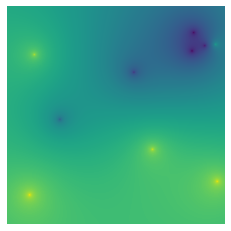

In [28]:
potential_cl_gpu = PotentialCL(
    open_cl_kernel, device_type="GPU", device_name=GPU_NAME
)
functions_dict["cl-gpu"] = potential_cl_gpu

potential_grid_cl_gpu = potential_cl_gpu(
    PARTICLE_COORDS, GRID_RESOLUTION, CHARGES
)
plot_potential_grid(potential_grid_cl_gpu)

In [29]:
benchmarks["ocl-gpu"] = %timeit -o potential_cl_gpu(PARTICLE_COORDS, GRID_RESOLUTION, CHARGES)

8.7 ms ± 461 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Benchmark Comparisons

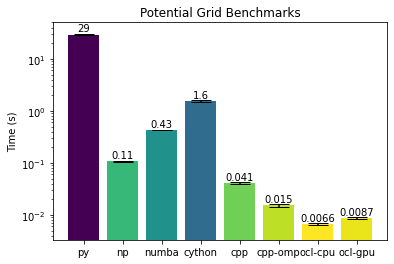

In [30]:
import plotting

funcs = []
times = []
stdevs = []
for func_name, result in benchmarks.items():
    funcs.append(func_name)
    times.append(result.average)
    stdevs.append(result.stdev)

fig, ax = plotting.plot_bar_chart(
    funcs, 
    times,
    yerr=stdevs,
    yscale="Log",
    capsize=10,
    title="Potential Grid Benchmarks", 
    ylabel="Time (s)"
);

In [31]:
from time import time

num_particles = 10
particle_coords = gen_particles(num_particles)
grid_resolutions = [50, 100, 200, 300, 500, 750, 1000, 1500, 3000, 5000]
charges = np.random.choice(np.int32([-1, 1]), (num_particles, ))
MAX_TIME = 3  # seconds

func_times = {x: [] for x in functions_dict.keys()}
for grid_resolution in grid_resolutions:
    for func_name, func in functions_dict.items():
        times = func_times[func_name]
        # Stop benchmarking when the function 
        # takes > n seconds
        if len(times) > 1 and times[-1] > MAX_TIME:
            continue
        start = time()
        func(particle_coords, grid_resolution, charges)
        func_times[func_name].append(time() - start)

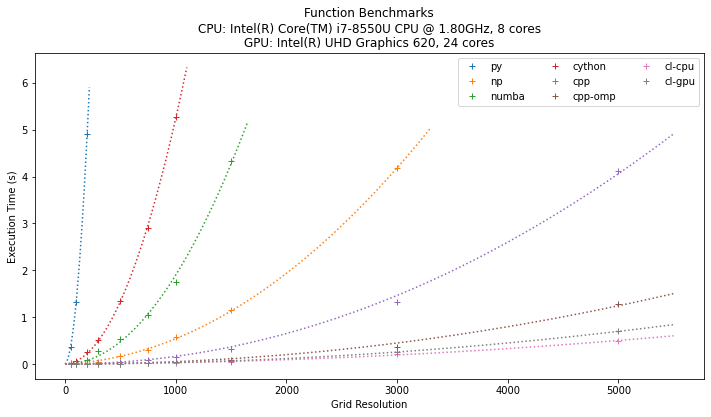

In [32]:
from scipy.optimize import curve_fit


def quadratic(x, a, b):
    """Quadratic that goes through origin"""
    return a*x**2 + b*x


fig, ax = plt.subplots(figsize=(12, 6))
for func_name, times in func_times.items():
    x = grid_resolutions[:len(times)]
    ax.plot(x, times, label=func_name, marker="+", linestyle="")
    
    # Fit quadratic to benchmarks; we expect time to scale
    # as grid_resolution^2
    popt, _ = curve_fit(quadratic, x, times, bounds=([0, 0], [np.inf, np.inf]))
    x_space = np.linspace(0, x[-1]*1.1, 200)
    ax.plot(
        x_space, 
        quadratic(x_space, *popt),
        linestyle=":", 
        marker="",
        color=ax.lines[-1].get_color()
    )

cpu_device = get_device("CPU")
gpu_device = get_device('GPU', GPU_NAME)
ax.set_title(
    f"Function Benchmarks\n"
    f"CPU: {cpu_device.name}, {cpu_device.max_compute_units} cores\n"
    f"GPU: {gpu_device.name}, {gpu_device.max_compute_units} cores")
ax.set_xlabel("Grid Resolution")
ax.set_ylabel("Execution Time (s)")
ax.legend(ncol=3, loc="upper right");